<a href="https://colab.research.google.com/github/nidhibendre/ANALYSIS-OF-PSEUDO-RANDOM-NUMBER-GENERATORS-PRNGs-through-Predictive-Modelling/blob/main/rng_neural_net_snowball.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

steps:
- pick a breakable random number generator
- figure out what the inputs and outputs for the model would be (what the hell are bits)
- attempt a crude feed-forward neural network to see if it can predict
- check its results and cry if it doesn't work

https://research.nccgroup.com/2021/10/15/cracking-random-number-generators-using-machine-learning-part-1-xorshift128/

potential other prngs:
- https://www.johndcook.com/blog/2019/04/14/randu/
https://en.wikipedia.org/wiki/Middle-square_method

data cleaning:
- given the last 4 randomly generated numbers A_1, A_2, A_3, A_4, can a neural net predict the next randomly generated number A_5
- The dataset should be straightforward to make (run xorshift128 a bunch of times and store A_1 - A_5 in a pandas dataframe and convert to bits) (please name your columns appropriately so you know what is X and what is Y)
- They use a different error function where being correct is 1 and being wrong is 0. see if this is implementable in pytorch

In [ ]:
import matplotlib.pyplot as plt

In [ ]:

import numpy as np
import pandas as pd

def xorshift128():
    '''xorshift
    https://ja.wikipedia.org/wiki/Xorshift
    '''

    x = 123456789
    y = 362436069
    z = 521288629
    w = 88675123

    def _random():
        nonlocal x, y, z, w
        t = x ^ ((x << 11) & 0xFFFFFFFF)  # 32bit
        x, y, z = y, z, w
        w = (w ^ (w >> 19)) ^ (t ^ (t >> 8))
        return w

    return _random

r = xorshift128()

vals = []
for i in range(10000):
    vals.append(r())


a_1 = []
for i in range(0, len(vals)-4):
    a_1.append(vals[i])

a_2 = []
for i in range(1, len(vals)-3):
    a_2.append(vals[i])

a_3 = []
for i in range(2, len(vals)-2):
    a_3.append(vals[i])

a_4 = []
for i in range(3, len(vals)-1):
    a_4.append(vals[i])

a_5 = []
for i in range(4, len(vals)):
    a_5.append(vals[i])

rng_df = pd.DataFrame(
    {
    'A_1': a_1,
    'A_2': a_2,
    'A_3': a_3,
    'A_4': a_4,
    'A_Pred': a_5
}
)
print(rng_df)

             A_1         A_2         A_3         A_4      A_Pred
0     3701687786   458299110  2500872618  3633119408   516391518
1      458299110  2500872618  3633119408   516391518  2377269574
2     2500872618  3633119408   516391518  2377269574  2599949379
3     3633119408   516391518  2377269574  2599949379   717229868
4      516391518  2377269574  2599949379   717229868   137866584
...          ...         ...         ...         ...         ...
9991  1873544304  2185597721  2711216717  2798608042  2840543623
9992  2185597721  2711216717  2798608042  2840543623   121426668
9993  2711216717  2798608042  2840543623   121426668  1775883212
9994  2798608042  2840543623   121426668  1775883212  3040864851
9995  2840543623   121426668  1775883212  3040864851  1722795530

[9996 rows x 5 columns]


In [ ]:
def convert_to_binary(number):
    # https://www.geeksforgeeks.org/python-program-to-convert-a-number-into-32-bit-binary-format/
    binary_str = bin(number)[2:]
    binary_32_bit = binary_str.zfill(32)
    return binary_32_bit

sample_bin = convert_to_binary(2798608042)
print(sample_bin)
print(type(sample_bin))
# sample_num = int(sample_bin)
# print(sample_num)
# print(type(sample_num))

10100110110011110101111010101010
<class 'str'>


- Turn X len 4 y len 1 into X len 128 y len 32 using the binary converter above
- seperate the data into train and test using sklearn train test split
- preferable: convert the data into tensors
- preferable: get model below to run

In [ ]:
df = pd.DataFrame(rng_df)
print(df.columns)
df.head()

Index(['A_1', 'A_2', 'A_3', 'A_4', 'A_Pred'], dtype='object')


,A_1,A_2,A_3,A_4,A_Pred
0,3701687786,458299110,2500872618,3633119408,516391518
1,458299110,2500872618,3633119408,516391518,2377269574
2,2500872618,3633119408,516391518,2377269574,2599949379
3,3633119408,516391518,2377269574,2599949379,717229868
4,516391518,2377269574,2599949379,717229868,137866584


In [ ]:
splitRows = []
for idx, row in df.iterrows():
  splitRow = {}
  for idx, col in enumerate(df.columns):
    for i in range(32):
      splitRow[str(col)+"_"+str(i+1)] = convert_to_binary(row[col])[i]
  splitRows.append(splitRow)
df_split = pd.DataFrame(splitRows)
df_split.head(5)

,A_1_1,A_1_2,A_1_3,A_1_4,A_1_5,A_1_6,A_1_7,A_1_8,A_1_9,A_1_10,...,A_Pred_23,A_Pred_24,A_Pred_25,A_Pred_26,A_Pred_27,A_Pred_28,A_Pred_29,A_Pred_30,A_Pred_31,A_Pred_32
0,1,1,0,1,1,1,0,0,1,0,...,1,0,0,1,0,1,1,1,1,0
1,0,0,0,1,1,0,1,1,0,1,...,0,1,0,1,0,0,0,1,1,0
2,1,0,0,1,0,1,0,1,0,0,...,0,0,0,1,0,0,0,0,1,1
3,1,1,0,1,1,0,0,0,1,0,...,1,1,0,0,1,0,1,1,0,0
4,0,0,0,1,1,1,1,0,1,1,...,0,1,0,1,0,1,1,0,0,0


In [ ]:
print(df_split)

     A_1_1 A_1_2 A_1_3 A_1_4 A_1_5 A_1_6 A_1_7 A_1_8 A_1_9 A_1_10  ...  \
0        1     1     0     1     1     1     0     0     1      0  ...   
1        0     0     0     1     1     0     1     1     0      1  ...   
2        1     0     0     1     0     1     0     1     0      0  ...   
3        1     1     0     1     1     0     0     0     1      0  ...   
4        0     0     0     1     1     1     1     0     1      1  ...   
...    ...   ...   ...   ...   ...   ...   ...   ...   ...    ...  ...   
9991     0     1     1     0     1     1     1     1     1      0  ...   
9992     1     0     0     0     0     0     1     0     0      1  ...   
9993     1     0     1     0     0     0     0     1     1      0  ...   
9994     1     0     1     0     0     1     1     0     1      1  ...   
9995     1     0     1     0     1     0     0     1     0      1  ...   

     A_Pred_23 A_Pred_24 A_Pred_25 A_Pred_26 A_Pred_27 A_Pred_28 A_Pred_29  \
0            1         0         

In [ ]:
# seperate out inputs and outputs, split into train and test groups
test_count = 100
X_train = df_split.iloc[:-test_count, :128]
y_train = df_split.iloc[test_count:, 128:]
X_test = df_split.iloc[:-test_count, :128]
y_test = df_split.iloc[test_count:, 128:]

In [ ]:
import torch
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(in_features=128, out_features=1024),
    nn.Linear(in_features=1024, out_features=32),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=128, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=32, bias=True)
  (2): Sigmoid()
)


In [ ]:
import torch.optim as optim
# optimizer = optim.Adam(model.parameters(), lr=0.01) # try this out see if its different
# loss_fn = nn.BCEWithLogitsLoss()

def train_model(model, X, y, iterations, loss_fn, optimizer):
    # keep track of summary statistics
    train_loss_list = []
    correct_predictions = 0

    # turn inputs and targets into tensors
    in_batch = torch.from_numpy(X.values.astype(np.float32))
    target_batch = torch.from_numpy(y.values.astype(np.float32))

    for iteration in range(iterations):
        #loss = loss_fn(predicted, y)
            # correct_predictions += (predicted.argmax(dim=1) == labels).sum().item()

        # use the model to make a guess
        out_batch = model(in_batch)

        # find the loss on the guess
        loss = loss_fn(out_batch, target_batch)

        # Backward pass (back propagation)
        model.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_list.append(loss.item())
    return train_loss_list
    # return np.mean(train_loss), correct_predictions / len(train_loader.dataset)

BCE Loss

The training loss should be going down:  [0.7023757100105286, 0.702286422252655, 0.7021986842155457, 0.7021122574806213, 0.7020272016525269, 0.7019436359405518, 0.7018613219261169, 0.701780378818512, 0.7017008066177368, 0.7016224265098572, 0.7015452980995178, 0.7014694809913635, 0.7013948559761047, 0.7013213634490967, 0.7012491822242737, 0.7011780738830566, 0.7011080980300903, 0.7010393738746643, 0.7009716629981995, 0.7009050846099854, 0.7008395791053772, 0.7007750272750854, 0.7007115483283997, 0.7006491422653198, 0.7005877494812012, 0.7005273103713989, 0.7004679441452026, 0.7004093527793884, 0.7003517746925354, 0.7002951502799988, 0.700239360332489, 0.7001845836639404, 0.7001305818557739, 0.700077474117279, 0.7000252604484558, 0.6999738812446594, 0.6999232769012451, 0.6998735666275024, 0.6998245120048523, 0.6997763514518738, 0.6997289061546326, 0.6996822357177734, 0.6996362805366516, 0.6995911002159119, 0.6995466947555542, 0.6995028853416443, 0.6994599103927612, 0.6994174718856812, 0.

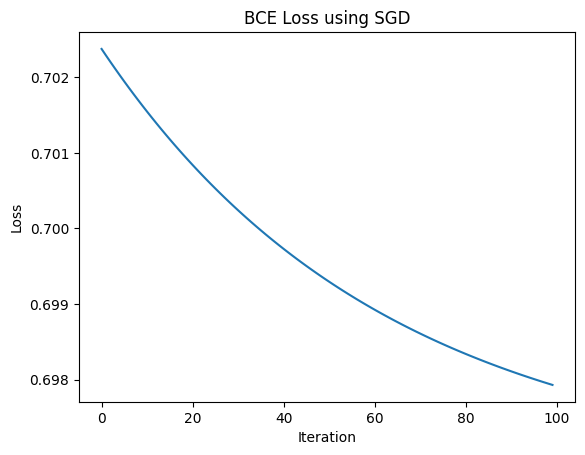

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.BCELoss()

# bce loss printing
train_loss_list_1_a = train_model(model, X_train, y_train, 100, loss_fn, optimizer)
print("The training loss should be going down: ", train_loss_list_1_a)

plt.title("BCE Loss using SGD")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(len(train_loss_list_1_a)), train_loss_list_1_a)
plt.show()

In [ ]:
# model testing
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    outputs = torch.round(model(X_test_tensor))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    # find bceloss
    loss = loss_fn(outputs, y_test_tensor)
    print(f"This is the loss using {loss_fn}: {loss}")

    # find bitwise accuracy
    print(outputs)
    print(y_test_tensor)

    matching_entry_count = torch.sum(outputs == y_test_tensor)
    total_entry_count = torch.numel(outputs)
    accuracy = matching_entry_count / total_entry_count
    print(matching_entry_count, total_entry_count, accuracy)
    print(f"This is the accuracy: {accuracy}")


This is the loss using BCELoss(): 50.0382080078125
tensor([[1., 1., 1.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 0.,  ..., 1., 0., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 0., 1.],
        [0., 1., 0.,  ..., 1., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 1.]])
tensor([[1., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.]])
tensor(158215) 316672 tensor(0.4996)
This is the accuracy: 0.49961790442466736


The training loss should be going down:  [0.6979119181632996, 1.7454941272735596, 1.9789458513259888, 0.8647579550743103, 1.464546799659729, 1.2593213319778442, 0.7647998929023743, 0.7921255826950073, 0.902762234210968, 0.7648858428001404, 0.7844659090042114, 0.9775642156600952, 0.8263794779777527, 0.7215689420700073, 0.8699251413345337, 0.8100833892822266, 0.6970160603523254, 0.7814782857894897, 0.812691867351532, 0.7299641370773315, 0.7059789896011353, 0.7419481873512268, 0.7394832372665405, 0.70640629529953, 0.697166383266449, 0.7117348313331604, 0.7195572257041931, 0.7110198736190796, 0.698660135269165, 0.6941587328910828, 0.6967352032661438, 0.6995722055435181, 0.698928713798523, 0.6958435773849487, 0.6928111910820007, 0.6911318898200989, 0.6906861066818237, 0.6907663941383362, 0.6907811164855957, 0.6905395984649658, 0.6901798844337463, 0.6899067759513855, 0.6897635459899902, 0.689614474773407, 0.6893087029457092, 0.6888455748558044, 0.6883891224861145, 0.6881362795829773, 0.68816

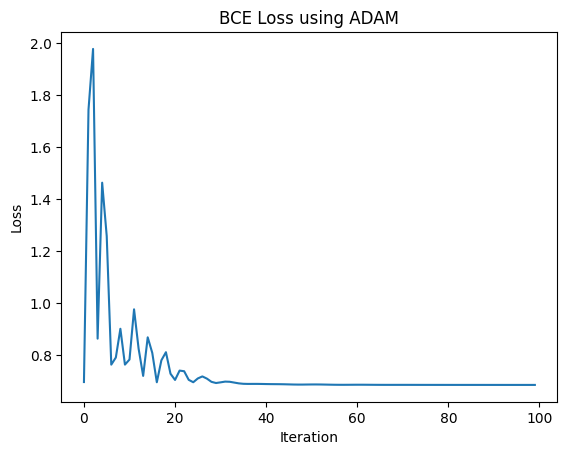

In [ ]:
# using ADAM
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_list_1_b = train_model(model, X_train, y_train, 100, loss_fn, optimizer)
print("The training loss should be going down: ", train_loss_list_1_b)

plt.title("BCE Loss using ADAM")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(len(train_loss_list_1_b)), train_loss_list_1_b)
plt.show()

In [ ]:
# model testing
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    outputs = torch.round(model(X_test_tensor))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    # find bceloss
    loss = loss_fn(outputs, y_test_tensor)
    print(f"This is the loss using {loss_fn}: {loss}")

    # find bitwise accuracy
    print(outputs)
    print(y_test_tensor)

    matching_entry_count = torch.sum(outputs == y_test_tensor)
    total_entry_count = torch.numel(outputs)
    accuracy = matching_entry_count / total_entry_count
    print(matching_entry_count, total_entry_count, accuracy)
    print(f"This is the accuracy: {accuracy}")

This is the loss using BCELoss(): 45.52186584472656
tensor([[1., 0., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[1., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.]])
tensor(172517) 316672 tensor(0.5448)
This is the accuracy: 0.5447813272476196


L1 Loss

The training loss should be going down:  [0.49378982186317444, 0.4937896132469177, 0.4937893748283386, 0.49378910660743713, 0.4937889277935028, 0.4937886595726013, 0.4937884211540222, 0.4937882423400879, 0.4937879741191864, 0.4937877357006073, 0.49378758668899536, 0.49378734827041626, 0.49378708004951477, 0.49378690123558044, 0.49378666281700134, 0.49378645420074463, 0.49378615617752075, 0.49378591775894165, 0.4937857687473297, 0.4937855303287506, 0.4937852621078491, 0.4937851130962372, 0.4937848746776581, 0.493784636259079, 0.4937843680381775, 0.49378418922424316, 0.49378395080566406, 0.4937836825847626, 0.49378353357315063, 0.49378323554992676, 0.49378305673599243, 0.4937828481197357, 0.493782639503479, 0.4937823712825775, 0.4937821626663208, 0.4937819540500641, 0.49378177523612976, 0.4937814772129059, 0.4937812089920044, 0.49378103017807007, 0.49378082156181335, 0.49378058314323425, 0.49378034472465515, 0.49378013610839844, 0.49377989768981934, 0.4937796890735626, 0.4937794506549835

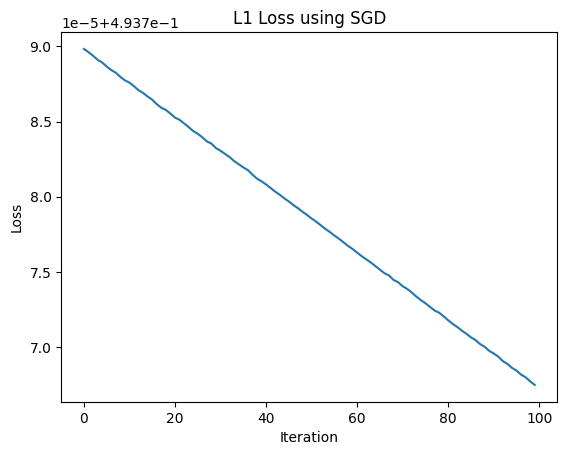

In [ ]:
loss_fn = nn.L1Loss()

# using SGD
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss_list_2_a = train_model(model, X_train, y_train, 100, loss_fn, optimizer)
print("The training loss should be going down: ", train_loss_list_2_a)

plt.title("L1 Loss using SGD")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(len(train_loss_list_2_a)), train_loss_list_2_a)
plt.show()

In [ ]:
# model testing
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    outputs = torch.round(model(X_test_tensor))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    # find bceloss
    loss = loss_fn(outputs, y_test_tensor)
    print(f"This is the loss using {loss_fn}: {loss}")

    # find bitwise accuracy
    print(outputs)
    print(y_test_tensor)

    matching_entry_count = torch.sum(outputs == y_test_tensor)
    total_entry_count = torch.numel(outputs)
    accuracy = matching_entry_count / total_entry_count
    print(matching_entry_count, total_entry_count, accuracy)
    print(f"This is the accuracy: {accuracy}")

This is the loss using L1Loss(): 0.45525023341178894
tensor([[1., 0., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 0., 1., 1.],
        [0., 1., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[1., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.]])
tensor(172507) 316672 tensor(0.5447)
This is the accuracy: 0.5447497963905334


The training loss should be going down:  [0.4937673509120941, 0.4876415431499481, 0.4880804419517517, 0.47895416617393494, 0.4749692678451538, 0.47274062037467957, 0.469555139541626, 0.46766534447669983, 0.46493709087371826, 0.46275824308395386, 0.46050286293029785, 0.458266019821167, 0.45705652236938477, 0.45494934916496277, 0.45281168818473816, 0.4515219032764435, 0.45024511218070984, 0.4488735496997833, 0.4474787712097168, 0.4464591443538666, 0.4450663924217224, 0.44377976655960083, 0.4430173337459564, 0.4422551691532135, 0.44113653898239136, 0.44100284576416016, 0.4403187334537506, 0.43875011801719666, 0.4379393458366394, 0.43793153762817383, 0.43626078963279724, 0.4356555640697479, 0.4352335035800934, 0.4342810809612274, 0.43400073051452637, 0.4332118034362793, 0.4336393475532532, 0.4339294731616974, 0.4332709014415741, 0.43187084794044495, 0.43183383345603943, 0.4312646985054016, 0.4310905337333679, 0.43072500824928284, 0.4302396774291992, 0.42978978157043457, 0.42956873774528503

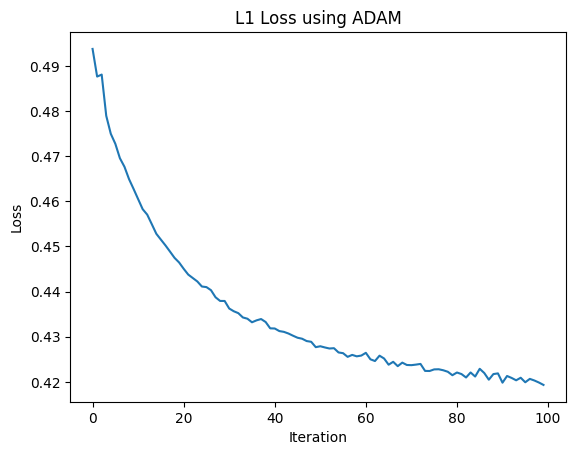

In [ ]:
# using ADAM
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_list_2_b = train_model(model, X_train, y_train, 100, loss_fn, optimizer)
print("The training loss should be going down: ", train_loss_list_2_b)

plt.title("L1 Loss using ADAM")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(len(train_loss_list_2_b)), train_loss_list_2_b)
plt.show()

In [ ]:
# model testing
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    outputs = torch.round(model(X_test_tensor))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    # find bceloss
    loss = loss_fn(outputs, y_test_tensor)
    print(f"This is the loss using {loss_fn}: {loss}")

    # find bitwise accuracy
    print(outputs)
    print(y_test_tensor)

    matching_entry_count = torch.sum(outputs == y_test_tensor)
    total_entry_count = torch.numel(outputs)
    accuracy = matching_entry_count / total_entry_count
    print(matching_entry_count, total_entry_count, accuracy)
    print(f"This is the accuracy: {accuracy}")

This is the loss using L1Loss(): 0.4152309000492096
tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.]])
tensor([[1., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.]])
tensor(185180) 316672 tensor(0.5848)
This is the accuracy: 0.584769070148468


Cross Entropy Loss

The training loss should be going down:  [56.00727081298828, 56.005943298339844, 56.004661560058594, 56.003421783447266, 56.0022087097168, 56.00102996826172, 55.99988555908203, 55.998775482177734, 55.99770736694336, 55.99665832519531, 55.99564743041992, 55.99466323852539, 55.993717193603516, 55.9927864074707, 55.99189758300781, 55.99103927612305, 55.990203857421875, 55.98939514160156, 55.98861312866211, 55.98785400390625, 55.98712158203125, 55.98641586303711, 55.98573303222656, 55.985069274902344, 55.984432220458984, 55.98381423950195, 55.983211517333984, 55.98263931274414, 55.98208236694336, 55.98154067993164, 55.981021881103516, 55.98051452636719, 55.980037689208984, 55.97956085205078, 55.9791145324707, 55.97867202758789, 55.978248596191406, 55.97783660888672, 55.977439880371094, 55.9770622253418, 55.976688385009766, 55.97633361816406, 55.975982666015625, 55.97564697265625, 55.97532272338867, 55.975013732910156, 55.97471237182617, 55.974422454833984, 55.9741325378418, 55.973857879638

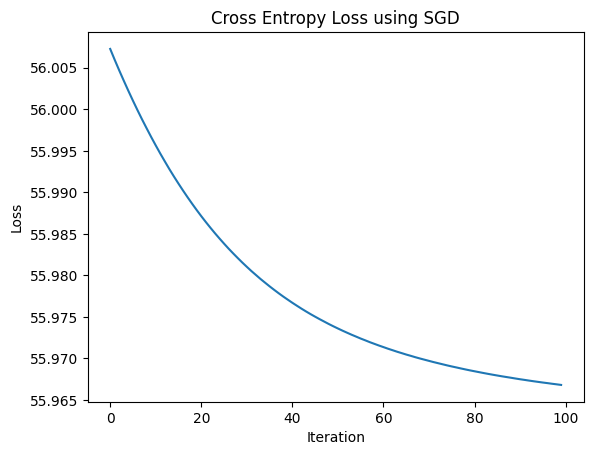

In [ ]:
loss_fn = nn.CrossEntropyLoss()
# using SGD
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss_list_3_a = train_model(model, X_train, y_train, 100, loss_fn, optimizer)
print("The training loss should be going down: ", train_loss_list_3_a)

plt.title("Cross Entropy Loss using SGD")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(len(train_loss_list_3_a)), train_loss_list_3_a)
plt.show()

In [ ]:
# model testing
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    outputs = torch.round(model(X_test_tensor))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    # find bceloss
    loss = loss_fn(outputs, y_test_tensor)
    print(f"This is the loss using {loss_fn}: {loss}")

    # find bitwise accuracy
    print(outputs)
    print(y_test_tensor)

    matching_entry_count = torch.sum(outputs == y_test_tensor)
    total_entry_count = torch.numel(outputs)
    accuracy = matching_entry_count / total_entry_count
    print(matching_entry_count, total_entry_count, accuracy)
    print(f"This is the accuracy: {accuracy}")

This is the loss using CrossEntropyLoss(): 55.99302673339844
tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [0., 1., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 1., 1., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 1.],
        [1., 1., 1.,  ..., 1., 0., 1.],
        [1., 0., 1.,  ..., 1., 1., 1.]])
tensor([[1., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.]])
tensor(186397) 316672 tensor(0.5886)
This is the accuracy: 0.5886121988296509


The training loss should be going down:  [55.971824645996094, 56.62607192993164, 56.61094284057617, 56.4395637512207, 56.23774719238281, 55.931297302246094, 55.70515823364258, 55.578041076660156, 55.526588439941406, 55.5010871887207, 55.49651336669922, 55.49583053588867, 55.49586868286133, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.49590301513672, 55.495

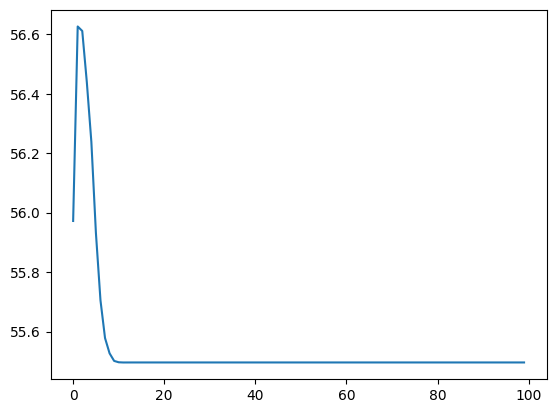

In [ ]:
# using ADAM
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_list_3_b = train_model(model, X_train, y_train, 100, loss_fn, optimizer)
print("The training loss should be going down: ", train_loss_list_3_b)
# for some reason, loss is increasing with epochs
# should we decrease learning rate after certain # of epochs (read online as possible soln)

plt.title("Cross Entropy Loss using ADAM")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(len(train_loss_list_3_b)), train_loss_list_3_b)
plt.show()

In [ ]:
# model testing
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    outputs = torch.round(model(X_test_tensor))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    # find bceloss
    loss = loss_fn(outputs, y_test_tensor)
    print(f"This is the loss using {loss_fn}: {loss}")

    # find bitwise accuracy
    print(outputs)
    print(y_test_tensor)

    matching_entry_count = torch.sum(outputs == y_test_tensor)
    total_entry_count = torch.numel(outputs)
    accuracy = matching_entry_count / total_entry_count
    print(matching_entry_count, total_entry_count, accuracy)
    print(f"This is the accuracy: {accuracy}")

This is the loss using CrossEntropyLoss(): 55.49590301513672
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[1., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.]])
tensor(158462) 316672 tensor(0.5004)
This is the accuracy: 0.5003978610038757


Smooth L1 Loss

The training loss should be going down:  [0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459

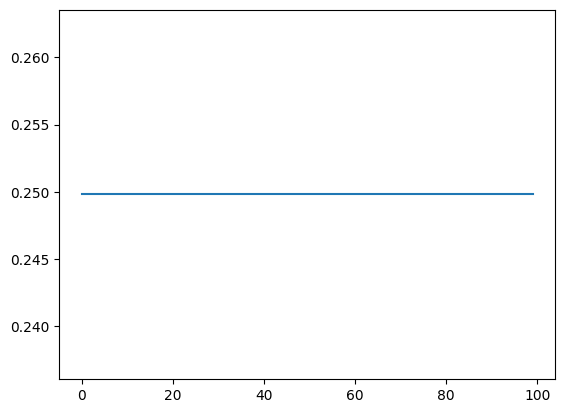

In [ ]:
loss_fn = nn.SmoothL1Loss()
# using SGD
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss_list_4_a = train_model(model, X_train, y_train, 100, loss_fn, optimizer)
print("The training loss should be going down: ", train_loss_list_4_a)

plt.title("Smooth L1 Loss using SGD")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(len(train_loss_list_4_a)), train_loss_list_4_a)
plt.show()

In [ ]:
# model testing
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    outputs = torch.round(model(X_test_tensor))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    # find bceloss
    loss = loss_fn(outputs, y_test_tensor)
    print(f"This is the loss using {loss_fn}: {loss}")

    # find bitwise accuracy
    print(outputs)
    print(y_test_tensor)

    matching_entry_count = torch.sum(outputs == y_test_tensor)
    total_entry_count = torch.numel(outputs)
    accuracy = matching_entry_count / total_entry_count
    print(matching_entry_count, total_entry_count, accuracy)
    print(f"This is the accuracy: {accuracy}")

This is the loss using SmoothL1Loss(): 0.24980105459690094
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[1., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.]])
tensor(158462) 316672 tensor(0.5004)
This is the accuracy: 0.5003978610038757


The training loss should be going down:  [0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459690094, 0.24980105459

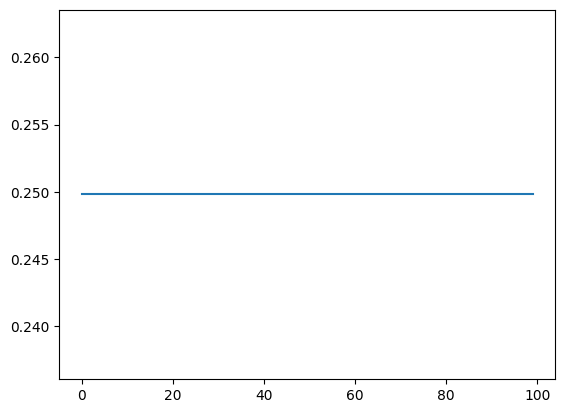

In [ ]:
# using ADAM
optimizer = optim.Adam(model.parameters(), lr=0.01)
train_loss_list_4_b = train_model(model, X_train, y_train, 100, loss_fn, optimizer)
print("The training loss should be going down: ", train_loss_list_4_b)

plt.title("Smooth L1 Loss using ADAM")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.plot(range(len(train_loss_list_4_b)), train_loss_list_4_b)
plt.show()

In [ ]:
# model testing
model.eval()
with torch.no_grad():
    X_test_tensor = torch.from_numpy(X_test.values.astype(np.float32))
    outputs = torch.round(model(X_test_tensor))
    y_test_tensor = torch.from_numpy(y_test.values.astype(np.float32))

    # find bceloss
    loss = loss_fn(outputs, y_test_tensor)
    print(f"This is the loss using {loss_fn}: {loss}")

    # find bitwise accuracy
    print(outputs)
    print(y_test_tensor)

    matching_entry_count = torch.sum(outputs == y_test_tensor)
    total_entry_count = torch.numel(outputs)
    accuracy = matching_entry_count / total_entry_count
    print(matching_entry_count, total_entry_count, accuracy)
    print(f"This is the accuracy: {accuracy}")

This is the loss using SmoothL1Loss(): 0.24980105459690094
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])
tensor([[1., 1., 1.,  ..., 0., 0., 1.],
        [0., 1., 1.,  ..., 1., 0., 1.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 1., 1.,  ..., 1., 0., 0.],
        [1., 0., 1.,  ..., 0., 1., 1.],
        [0., 1., 1.,  ..., 0., 1., 0.]])
tensor(158462) 316672 tensor(0.5004)
This is the accuracy: 0.5003978610038757


Output Layer Activation of Softmax

In [ ]:
# THIS IS CODE FROM RESEARCH DOCUMENT, DO NOT LEAVE HERE
# https://research.nccgroup.com/2021/10/15/cracking-random-number-generators-using-machine-learning-part-1-xorshift128/
RNG_NAME = "xorshift128plus"
IMPORT_COUNT = 4000000
TEST_COUNT = 100
LOSS_FUNCTION = nn.BCELoss()
METRIC_FUNCTION = 'accuracy'
BATCH_SIZE= 1024
PREV_COUNT = 2

input_size = 128
output_size = 1
num_heads = 4
dim_feedforward = 2

class Model(nn.Module):
    def __init__(self, input_size, output_size, num_heads, dim_feedforward):
        super(Model, self).__init__()
        self.transformer = nn.TransformerEncoderLayer(dropout=0,d_model=input_size, nhead=num_heads, dim_feedforward=dim_feedforward)
        self.out = nn.Linear(input_size, output_size)
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.transformer(x)
        x = self.out(x)
        x = self.sig(x)
        return x


model = Model(X.shape[1], 1, num_heads=4, dim_feedforward=2).to(device)
optimizer = torch.optim.NAdam(model.parameters(), lr=0.01, eps=1e-08)
criterion = LOSS_FUNCTION
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min',threshold=0.001,patience=2,cooldown=3)
for epoch in range(500):
    total_loss = 0.0
    model.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    scheduler.step(total_loss)
    print('Epoch:', epoch, 'Loss:', total_loss / len(train_loader))
# model evaluation
model.eval()
with torch.no_grad():
    outputs = model(X_test)
    loss = criterion(outputs, y_test)
    print('Test Loss:', loss.item())
    print(outputs[0],y_test[0])

AssertionError: embed_dim must be divisible by num_heads